In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
lr = 0.00005
batch_size = 128
image_size = 64
channels_img = 3
z_dim = 100
num_epochs = 5
features_disc = 64
features_gen = 64

cuda


In [3]:
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 5e-5

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
   print('User uploaded file "{name}" with length {length} bytes'.format(
       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset

!unzip "celeba-dataset.zip" -d "/celeba/"

dataroot = "/celeba"

Streaming output truncated to the last 5000 lines.
  inflating: /celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /celeba/img_align_celeba/img_align_celeba/197617.jpg

In [36]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [37]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

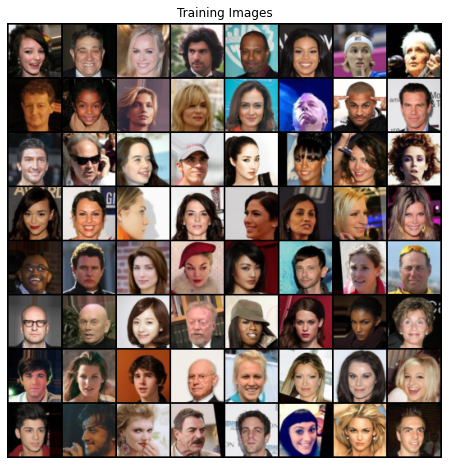

In [50]:
workers = 2
#dataroot = "/vast/aj3281/celeba-dataset"
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [51]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [52]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [53]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [62]:
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

In [63]:
step = 0
netG.train()
netD.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [68]:
def get_noise(n_samples, noise_dim, device='cpu'):
    '''
    Generate noise vectors from the random normal distribution with dimensions (n_samples, noise_dim),
    where
        n_samples: the number of samples to generate based on  batch_size
        noise_dim: the dimension of the noise vector
        device: device type can be cuda or cpu
    '''
    
    return  torch.randn(n_samples,noise_dim, 1,1,device=device)

In [66]:
def gradient_penalty( critic, real_image, fake_image, device):
    #print(real_image.shape)
    batch_size, channel, height, width= real_image.shape
    #alpha is selected randomly between 0 and 1
    #print(batch_size)
    alpha= torch.rand(batch_size,1,1,1).repeat(1, channel, height, width).to(device)
    # interpolated image=randomly weighted average between a real and fake image
    #interpolated image ← alpha *real image  + (1 − alpha) fake image
    real_image = real_image.to(device)
    fake_image = fake_image.to(device)
    #print(fake_image.shape)
    interpolatted_image=(alpha*real_image) + (1-alpha) * fake_image
    
    interpolatted_image = interpolatted_image.to(device)
    # calculate the critic score on the interpolated image
    interpolated_score= critic(interpolatted_image)
    interpolated_score = interpolated_score.to(device)
    # take the gradient of the score wrt to the interpolated image
    gradient= torch.autograd.grad(inputs=interpolatted_image,
                                  outputs=interpolated_score,
                                  retain_graph=True,
                                  create_graph=True,
                                  grad_outputs=torch.ones_like(interpolated_score)                          
                                 )[0]
    gradient= gradient.view(gradient.shape[0],-1)
    gradient_norm= gradient.norm(2,dim=1)
    gradient_penalty=torch.mean((gradient_norm-1)**2)
    return gradient_penalty

In [72]:
LAMBDA_GP = 10
num_epochs = 10

for epoch in range(num_epochs):
  for batch_idx, (real, _) in enumerate(dataloader):
    real = real.to(device)
    cur_batch_size = real.shape[0]
    for _ in range(5):
       netD.zero_grad()
       fake_noise = get_noise(cur_batch_size, z_dim, device=device)   
       fake = netG(fake_noise)
       critic_real = netD(real).reshape(-1)
       critic_fake = netD(fake).reshape(-1)
       #loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
       gp =gradient_penalty(netD, real, fake, device)
       gp = gp.to(device)
       loss_critic = -(torch.mean(critic_real) -torch.mean(critic_fake)) + LAMBDA_GP *gp
       netD.zero_grad()
       loss_critic.backward(retain_graph = True)
       optimizerD.step()

       
    
    netG.zero_grad()
    output = netD(fake).reshape(-1)
    loss_gen = -torch.mean(output)
    
    loss_gen.backward()
    optimizerG.step()
    
    if batch_idx%100 == 0:
      print (
          f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} \ Loss D: {loss_critic :.4f}, loss G: {loss_gen:.4f}"
      ) 

Epoch [0/10] Batch 0/1583 \ Loss D: -7.7413, loss G: -139.2027
Epoch [0/10] Batch 100/1583 \ Loss D: -9.8841, loss G: -149.3081
Epoch [0/10] Batch 200/1583 \ Loss D: -5.8793, loss G: -139.3372
Epoch [0/10] Batch 300/1583 \ Loss D: -270.2773, loss G: 58.7594
Epoch [0/10] Batch 400/1583 \ Loss D: -8.1166, loss G: -144.8368
Epoch [0/10] Batch 500/1583 \ Loss D: -8.0099, loss G: -126.4113
Epoch [0/10] Batch 600/1583 \ Loss D: -21.1528, loss G: -145.2029
Epoch [0/10] Batch 700/1583 \ Loss D: -275.0807, loss G: -230.4620
Epoch [0/10] Batch 800/1583 \ Loss D: -6.4272, loss G: -148.9245
Epoch [0/10] Batch 900/1583 \ Loss D: -7.2071, loss G: -143.4836
Epoch [0/10] Batch 1000/1583 \ Loss D: -7.9748, loss G: -138.0142
Epoch [0/10] Batch 1100/1583 \ Loss D: 1.3056, loss G: -134.0614
Epoch [0/10] Batch 1200/1583 \ Loss D: -11.7923, loss G: -135.6257
Epoch [0/10] Batch 1300/1583 \ Loss D: -3.3596, loss G: -138.5995
Epoch [0/10] Batch 1400/1583 \ Loss D: -10.2622, loss G: -138.8016
Epoch [0/10] Batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

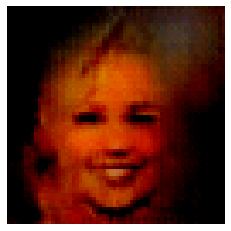

In [73]:
with torch.no_grad():
      fake = netG(fixed_noise).detach().cpu()
#img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

fig = plt.figure(figsize=(4,4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in fake]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [74]:
model_file = 'WGAN_discriminator_model_new4.pth'
torch.save(netD, model_file)

model_file = 'WGAN_generator_model_new4.pth'
torch.save(netG, model_file)

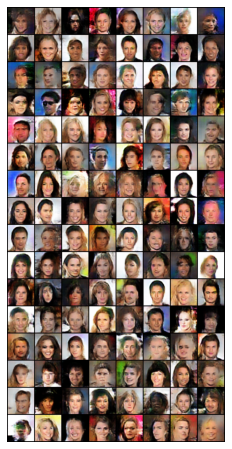

In [75]:
img_list = []
fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())